## ISDAC data loader

In [168]:
import pandas as pd
import xarray
import glob
import statistics
from datetime import datetime
from time import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'datetime', 'time', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Load bulk parameters from ISDAC

In [90]:
data_path = 'data//convair//*'
file_list = glob.glob(data_path)

df_list = []
for f in file_list:
    flight_no = f[-13:-11]
    # First, parse date out of second line of file
    text = open(f)
    text.readline()
    date = datetime.datetime.strptime(text.readline()[13:24], "%Y/%b/%d")
    text.close()
    df = pd.read_csv(f, header=3, skiprows=[4,5], parse_dates=[1,2,3])
    df['flight_number'] = int(flight_no)
    times = []
    for i in range(len(df[' HH'])):
        times.append(datetime.datetime(year=date.year, month=date.month, day=date.day,
                              hour=int(df[' HH'][i]), minute=int(df['MM'][i]), 
                                       second=int(df['SS'][i])))
        
    df['time'] = times
    df.set_index('time')
    df_list.append(df)

# Concatenate
isdac_df = pd.concat(df_list)
isdac_df = isdac_df.set_index('time')

# Handle missing values
isdac_df = isdac_df.replace(-8.888, np.nan)
del df_list

In [92]:
isdac_df['  CVI_Eh'][0]

nan

In [93]:
CSI_TWC = isdac_df[' CSI_TCWC'] ## Ice water contents from CSI


## Load Microphysics PI Product - Ice PSDs and phase

We used different bins for different days depending on what probes were working. For this simple course we will keep it simple and just use the days where we had 126 ice bins (most of the days)

In [268]:
microphysics_list = glob.glob('data//microphysics//*.nc')
microphysics_list = sorted(microphysics_list)
ds_list = []
prev_date = datetime.datetime(2004,1,1,1,1)
for files in microphysics_list:
    microphysics_ds = xarray.open_dataset(files)
    if(len(microphysics_ds.ice_bin_length) == 126):
        # Since ice PSD bins vary vs time, we need to make a new xarray Dataset with 
        # ice PSDs varying in time for each day
        # Also, convert the Time to pythonic datetimes

        the_date = datetime.datetime.strptime(files[-14:-8], '%y%m%d')
        
        times = [datetime.datetime.strptime("%06d" % tiempo, '%H%M%S') 
                 for tiempo in microphysics_ds.Time.values]
        if(not the_date == prev_date):
            first_hour = times[0].hour
            
        prev_date = the_date    
        dt_list = []

        for tiempo in times:
            if(tiempo.hour < first_hour):
                dt_list.append(datetime.datetime(year=the_date.year, month=the_date.month,
                                     day=the_date.day+1, hour=tiempo.hour,
                                     minute=tiempo.minute, second=tiempo.second)) 
            else:
                dt_list.append(datetime.datetime(year=the_date.year, month=the_date.month,
                                     day=the_date.day, hour=tiempo.hour,
                                     minute=tiempo.minute, second=tiempo.second))

        microphysics_ds['utctime'] = (('time'), dt_list)
        microphysics_ds = microphysics_ds.set_index('utctime')
        ice_bin_min = microphysics_ds.bin_ice_min
        ice_bin_mid = microphysics_ds.bin_ice_mid
        ice_bin_max = microphysics_ds.bin_ice_max
        ice_bin_dD = microphysics_ds.bin_ice_dD
        N_i_binned = microphysics_ds.N_i_binned
        utctime = microphysics_ds['utctime']
        try:
            phaseID = microphysics_ds.phaseID
            new_ds = xarray.Dataset({'ice_bin_min': ice_bin_min,
                                     'ice_bin_mid': ice_bin_mid,
                                     'ice_bin_max': ice_bin_max,
                                     'ice_bin_dD': ice_bin_dD,
                                     'N_i_binned': N_i_binned,
                                     'phaseID': phaseID,
                                     'time': utctime})
            ds_list.append(new_ds)
        except AttributeError:
            print("No phase information on " + str(the_date) + ", not adding.")

PSDs = xarray.concat(ds_list, dim='time')
print(PSDs)

No phase information on 2008-04-08 00:00:00, not adding.
<xarray.Dataset>
Dimensions:      (ice_bin_length: 126, time: 259752)
Coordinates:
  * time         (time) datetime64[ns] 2008-04-01T19:59:41 ...
Dimensions without coordinates: ice_bin_length
Data variables:
    ice_bin_min  (time, ice_bin_length) float64 2.0 3.0 4.0 5.0 6.0 7.0 8.0 ...
    ice_bin_mid  (time, ice_bin_length) float64 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...
    ice_bin_max  (time, ice_bin_length) float64 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
    ice_bin_dD   (time, ice_bin_length) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    N_i_binned   (time, ice_bin_length) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    phaseID      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


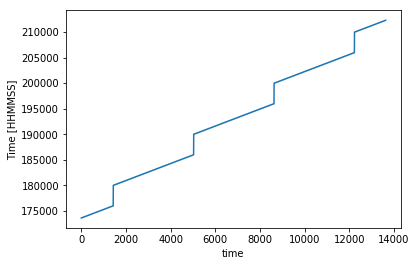

In [266]:
microphysics_ds = xarray.open_dataset(microphysics_list[2])
microphysics_ds.Time.plot()

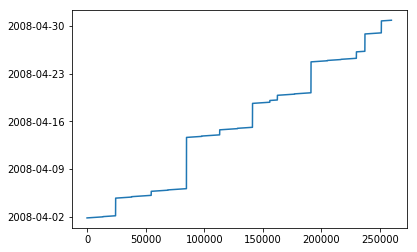

In [270]:
plt.plot(PSDs.time.values)

## Do averaging and reindexing to same times

In [296]:
CSI_TWC_10s = CSI_TWC.reindex(index=PSDs.time).resample('10s').mean()

N_i_binned_10s = PSDs.N_i_binned.rolling(time=10).mean()
phase_id_10s = PSDs.phaseID.reindex(time=N_i_binned_10s.time)
bin_ice_mid = PSDs.bin_ice_mid.isel(time=1)
bin_ice_min = PSDs.bin_ice_min.isel(time=1)
bin_ice_max = PSDs.bin_ice_max.isel(time=1)
bin_ice_dD = PSDs.bin_ice_dD.isel(time=1)

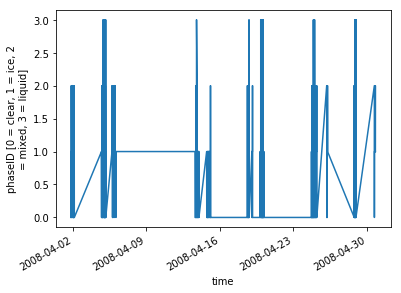

In [302]:
phase_id_10s.plot()

# Have fun with your science here!